In [1]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from scipy import interpolate, signal
import torch
import torch.nn.functional as tfun

import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [12, 8]

# 4.2 Explore the data in ITK-SNAP (5 points)

- The 6 combinations (2 transformation models x 3 image similarity metrics) of registration settings all were able to minimize the metric. The difference was between the number of iterations it took to achieve this. Visually, all except Rigid + Cross-correlation (pictured below) looked to have achieved similar results with the segmentation matching across the two images as well.
- Manual registration has a total of 9 tunable parameters (3 each for rotation, translation, and scaling). It is almost impossible to achieve the correct combination of all 9 manually to get correct registration.

![registration](./registration.png)

Rigid transformation with cross-correlation metric did not give the best results visually. ![rigidcc](./itksnapreg.png) 

All other combinations of transformation models and image similarity metrics achieved similar looking results. ![affine-mi](./itksnapreg2.png)

# 4.3 Loading and displaying 3D images with python (10 points)

Writing custom functions to read, write, and view NIfTI images. The view function outputs the axial, sagittal, and coronal views at a given cross-hair location along with the colorbar.

## Read images

In [2]:
def my_read_nifti(filename):
    """Read NIfTI image voxels and header

    :param filename: path to image to read
    :return: tuple (img, hdr) consisting of numpy voxel array and nibabel NIfTI header
    """    
    img = nib.load(filename)
    
    return img.get_fdata(), img.header

## Write images

In [3]:
def my_write_nifti(filename, img, header=None):
    """Write NIfTI image voxels and header

    :param filename: path to the image to save
    :param img: numpy voxel array
    :param header: nibabel NIfTI header, defaults to None
    """
    if header is not None:
        nifti_img = nib.Nifti1Image(img, affine=header.get_best_affine(), header=header)
    else:
        # defaults to 1mm spacing when header not specified
        nifti_img = nib.Nifti1Image(img, affine=np.ones((len(img.shape), 1)))
        
    nib.save(nifti_img, filename)

## View images

In [4]:

def my_view(img, xhair=None, header=None, crange=None, cmap='gray', title=None):
    """Display a 3D image in a layout similar to ITK-SNAP

    :param img: 3D voxel array
    :param xhair: crosshair position
    :param header: image header (returned by my_read_nifti), defaults to None
    :param crange: intensity range tuple with min and max values, defaults to None
    :param cmap: colormap (see matplotlib docs), defaults to 'gray'
    """
    vmin = None
    vmax = None
    
    if crange is not None:
        vmin = crange[0]
        vmax = crange[1]

    if xhair is None:
        xhair = (int(img.shape[0]/2), int(img.shape[1]/2), int(img.shape[2]/2))
            
    fig, ax = plt.subplots(2, 2)

    im1 = ax[0, 0].imshow(img[:, :, xhair[2]], cmap=cmap, vmin=vmin, vmax=vmax)

    # need to transpose each image and invert axes to get the correct
    # orientations of the views

    # axial view (y, x)
    ax[0, 0].imshow(img[:, :, xhair[2]].transpose(), cmap=cmap, vmin=vmin, vmax=vmax)
    ax[0, 0].invert_xaxis()
    ax[0, 0].invert_yaxis()
    ax[0, 0].axvline(xhair[0])
    ax[0, 0].axhline(xhair[1])
    
    # sagittal view (z, y)
    ax[0, 1].imshow(img[xhair[0], :, :].transpose(), cmap=cmap, vmin=vmin, vmax=vmax)
    ax[0, 1].invert_xaxis()
    ax[0, 1].invert_yaxis()
    ax[0, 1].axvline(xhair[1])
    ax[0, 1].axhline(xhair[2])
    
    # colorbar
    ax[1, 0].axis('off')
    cax = plt.axes([0.175, 0.15, 0.3, 0.05])
    plt.colorbar(im1, orientation='horizontal', ax=ax[0,0], cax=cax)

    # coronal view (z, x)
    ax[1, 1].imshow(img[:, xhair[1], :].transpose(), cmap=cmap, vmin=vmin, vmax=vmax)
    ax[1, 1].invert_xaxis()
    ax[1, 1].invert_yaxis()
    ax[1, 1].axvline(xhair[2])
    ax[1, 1].axhline(xhair[0])
    
    # extract the correct aspect ratios from header information
    if header is not None:
        # pixdim[1] is spacing in x
        # pixdim[2] is spacing in y
        # pixdim[3] is spacing in z
        ax[0, 0].set_aspect(header['pixdim'][2]/header['pixdim'][1])
        ax[0, 1].set_aspect(header['pixdim'][3]/header['pixdim'][2])
        ax[1, 1].set_aspect(header['pixdim'][3]/header['pixdim'][1])
        
    fig.suptitle(f"{title} \nxhair loc {xhair}")

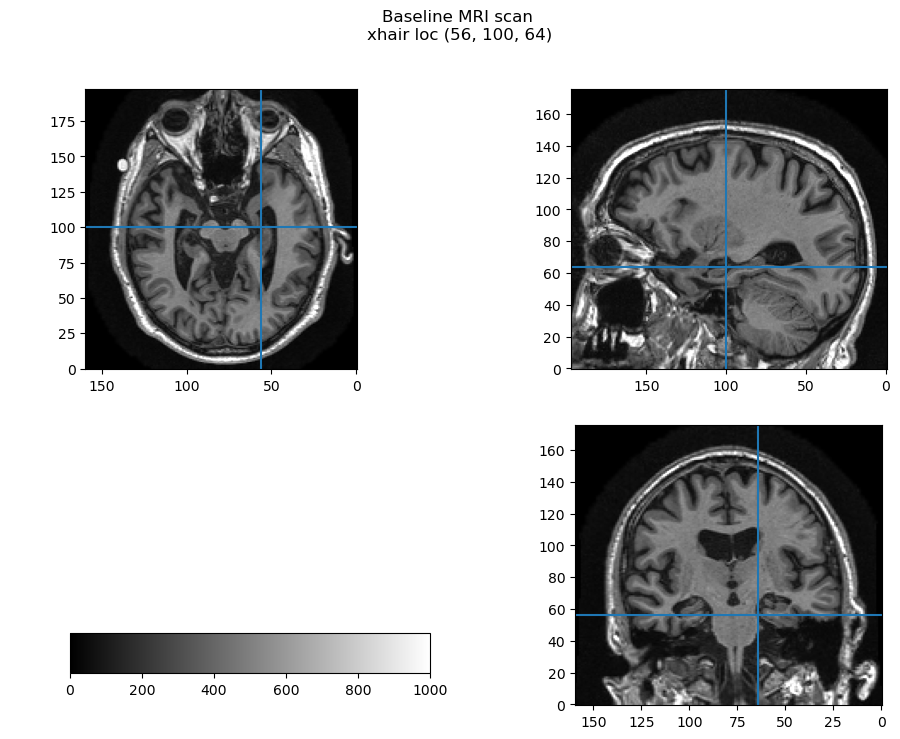

In [5]:
# read in baseline image
img, hdr = my_read_nifti("data/baseline.nii")

my_view(img, xhair=(56,100,64), header=hdr, crange=(0, 1000),
        title="Baseline MRI scan")

# 5.1 Apply affine transformations to 3D images (10 points)
Extract the transform matrix and translation vector from file. Apply the transformation to meshgrid coordinates to get the transformed coordinates. Interpolate the moving image to get voxel values at the transformed coordinates. This is the resampled, transformed image.

## Read transform from file

In [6]:
def my_read_transform(filename):
    """Read 3D transform (4x4 matrix) from file

    :param filename: file containing transform matrix
    :return: tuple (A, b) where A is 3x3 affine matrix, b is translation vector
    """
    Ab = np.loadtxt(filename)
    
    A = Ab[:3, :3]
    b = np.expand_dims(Ab[:3, 3], axis=1) # dimension (3, 1) instead of (3,)
    
    return A, b 

## Apply transform to image

In [7]:
def my_transform_image(I_ref, I_mov, A, b, method='linear', fill_value=0):
    """Transform a moving image into the space of the fixed field

    :param I_ref: 3D voxel array of the fixed (reference) image
    :param I_mov: 3D voxel array of the moving image
    :param A: 3x3 affine transformation matrix
    :param b: 3x1 translation vector
    :param method: interpolation method, defaults to 'linear'
    :param fill_value: value with which to replace missing values, defaults to 0
    :return: 3D voxel array of the affine-transformed moving image
    """
    # get number of points along each dimension
    nx, ny, nz = I_ref.shape
    x = np.linspace(0, nx-1, nx)
    y = np.linspace(0, ny-1, ny)
    z = np.linspace(0, nz-1, nz)

    # generate 3D grid coordinates
    xp, yp, zp = np.meshgrid(x, y, z, indexing='ij')
    Xp = np.stack((xp, yp, zp))
    
    Xp = np.reshape(Xp, newshape=(3, -1))

    # T(Xp) = A*Xp + b
    TXp = np.dot(A, Xp) + b

    I_res = interpolate.interpn((x, y, z), I_mov, TXp.T, method=method, 
                                bounds_error=False, fill_value=fill_value)
    
    I_res = np.reshape(I_res, newshape=I_ref.shape)

    return I_res    

In [8]:
# read in baseline image
I_ref, hdr_ref = my_read_nifti("data/baseline.nii")
# read in follow up image
I_mov, hdr_mov = my_read_nifti("data/followup.nii")

# read in transform matric
A, b = my_read_transform("data/f2b.txt")

# get transformed image
I_res = my_transform_image(I_ref, I_mov, A, b)

### View resampled follow up image

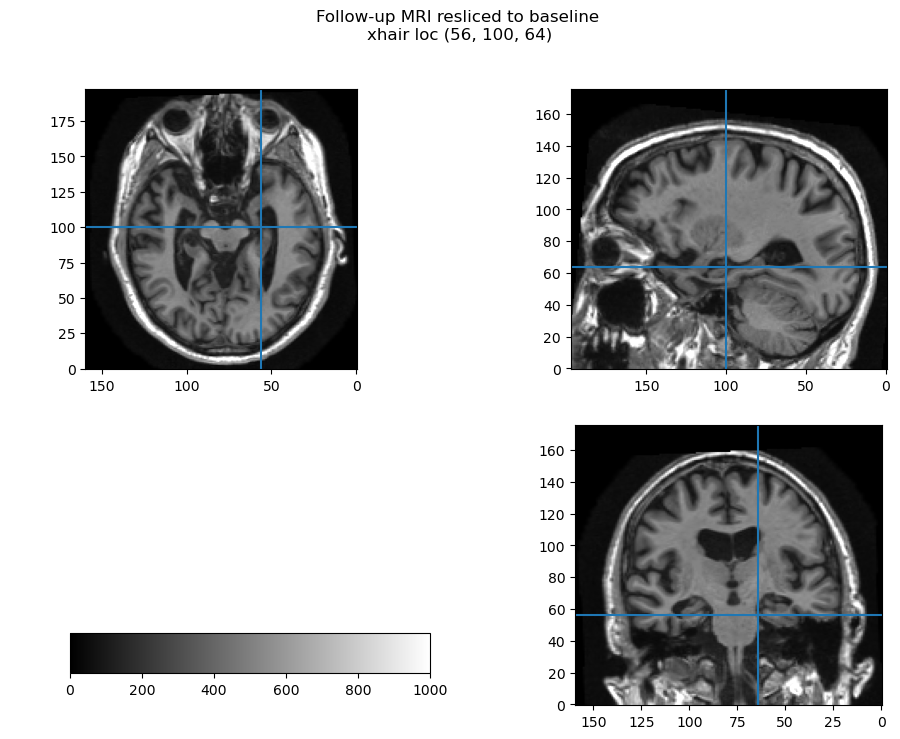

In [9]:
my_view(I_res, xhair=(56,100,64), header=hdr_mov, crange=(0, 1000),
        title="Follow-up MRI resliced to baseline")

### View baseline image

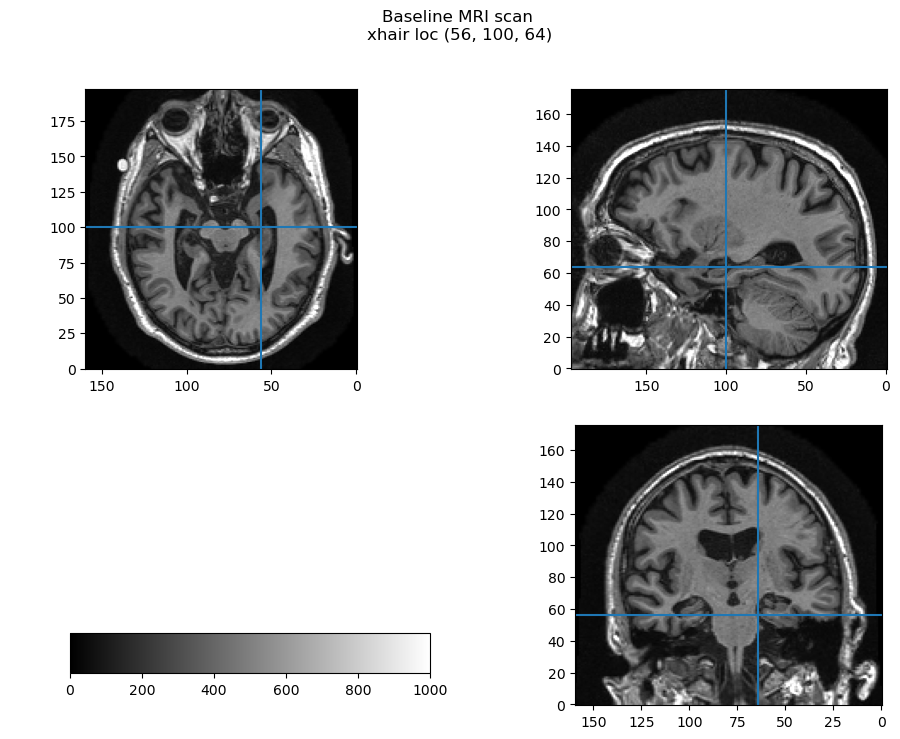

In [10]:
my_view(I_ref, xhair=(56,100,64), header=hdr_ref, crange=(0, 1000),
        title="Baseline MRI scan")

# 5.2 Effects of low pass filtering on difference image computation (15 points)
Implement Gaussian and mean low pass filters. Examine how low pass filtering affects the computation of differences between the baseline image and the affine-transformed followup image.

## Implement Gaussian low-pass filtering for 3D volumes

In [11]:
def my_gaussian_lpf(image, sigma):
    """Apply 3D Gaussian low-pass filtering to an image

    :param image: 3D voxel array om the input image
    :param sigma: std dev of the Gaussian kernel in voxel units
    :return: 3D voxel array of the filtered image
    """
    # generate sample points and compute the value of Gaussian at these points
    # the number of sample points is determined from the sigma value
    halfsize = int(np.ceil(3.5 * sigma))
    x = np.linspace(-halfsize, halfsize, 2*halfsize+1)
    
    # compute the values
    # this gives us a 1D Gaussian
    G = np.exp(-np.power(x/sigma, 2) / 2)/(sigma * np.sqrt(2*np.pi))
    
    # generate Gaussians along each dimension
    Gz = np.expand_dims(G, axis=(1, 0)) # (1, 1, size)
    Gy = np.expand_dims(G, axis=(2, 0)) # (1, size, 1)
    Gx = np.expand_dims(np.expand_dims(G, axis=1), axis=1) # (size, 1, 1)

    G = Gx * Gy * Gz # 3D Gaussian (size, size, size)
    
    # convolve (using FFT for the more optimal implementation) image signal
    # with the Gaussian filter to get lowpass filtered image
    lpf_img = signal.fftconvolve(image, G, mode='same')
    
    return lpf_img

### Visualize Gaussian low pass filtered delta signal

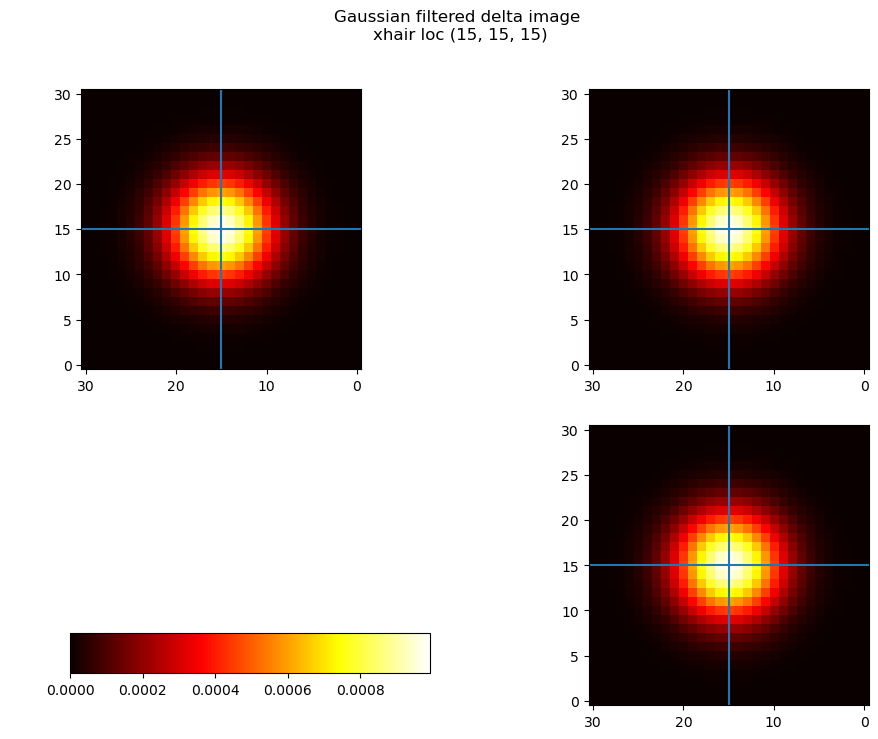

In [12]:
# generate delta function image 
# all pixels except the center are 0, center pixel is 1
delta = np.zeros(shape=(31, 31, 31))
delta[15, 15, 15] = 1

lpf_delta = my_gaussian_lpf(delta, sigma=4)

my_view(lpf_delta, cmap='hot', title="Gaussian filtered delta image")

### Baseline image filtered with Gaussian filter at $\sigma$ = 2

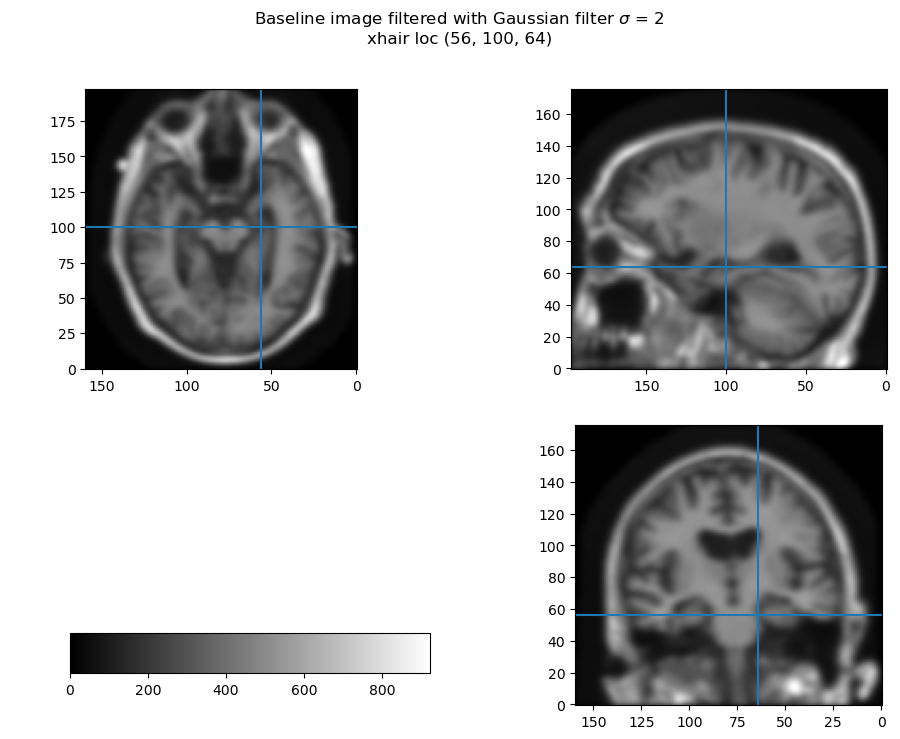

In [13]:
I_ref_gaussian_lpf = my_gaussian_lpf(I_ref, sigma=2)

my_view(I_ref_gaussian_lpf, xhair=(56,100,64), header=hdr_ref, 
        title="Baseline image filtered with Gaussian filter $\sigma$ = 2")

## Implement mean filtering

In [14]:
def my_mean_lpf(image, radius):
    """Apply 3D mean filtering to an image

    :param image: 3D voxel numpy array
    :param radius: size of the mean filter
    :return: mean filtered image
    """    
    size = int(2*radius + 1)
    mean_lpf = np.ones(shape=(size, size, size))/size**3
    
    mean_lpf_image = signal.fftconvolve(image, mean_lpf, mode='same')
    
    return mean_lpf_image

### Baseline image filtered with mean filter radius=2

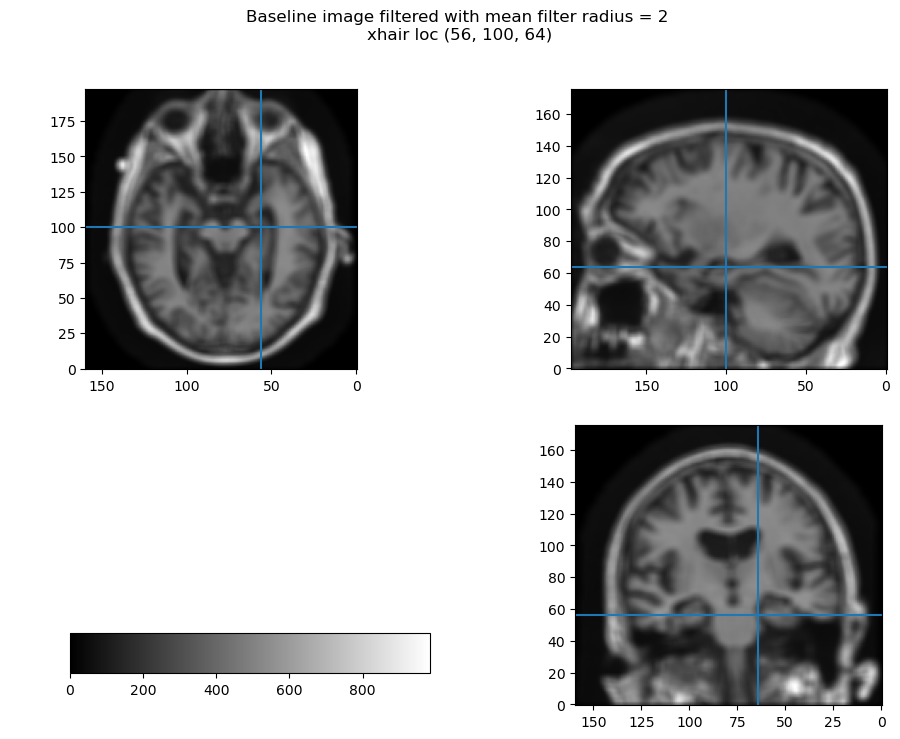

In [15]:
I_ref_mean_lpf = my_mean_lpf(I_ref, radius=2)

my_view(I_ref_mean_lpf, xhair=(56,100,64), header=hdr_ref,
        title="Baseline image filtered with mean filter radius = 2")

## Compute and show difference images
$K_B$ is the preprocessing done on the baseline image. $K_F$ is the preprocessing done on the follow-up image before resampling.  
The difference image is $ D(\textbf{x}) = R[(I_F \circ K_F)](\textbf{x}) - (I_B \circ K_B)(\textbf{x}) $

### 1. $K_B$ = None, $K_F$ = None, Interpolation = Nearest neighbor

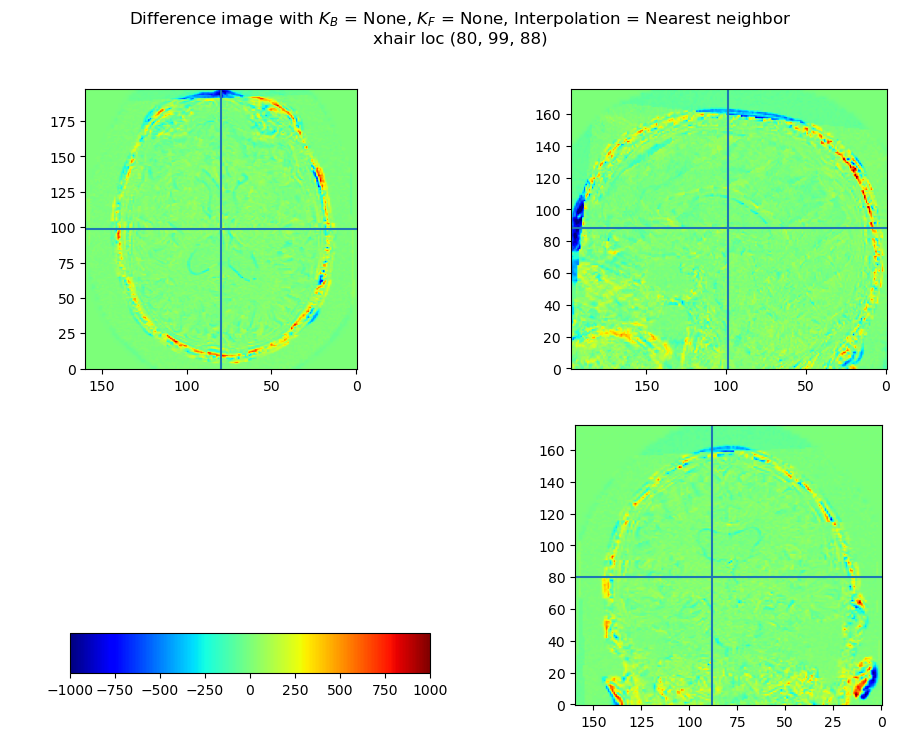

In [16]:
diff1 = my_transform_image(I_ref, I_mov, A, b, method='nearest') - I_ref

my_view(diff1, header=hdr_ref, crange=(-1000, 1000), cmap='jet',
        title="Difference image with $K_B$ = None, $K_F$ = None, Interpolation = Nearest neighbor")

### 2. $K_B$ = None, $K_F$ = None, Interpolation = Linear

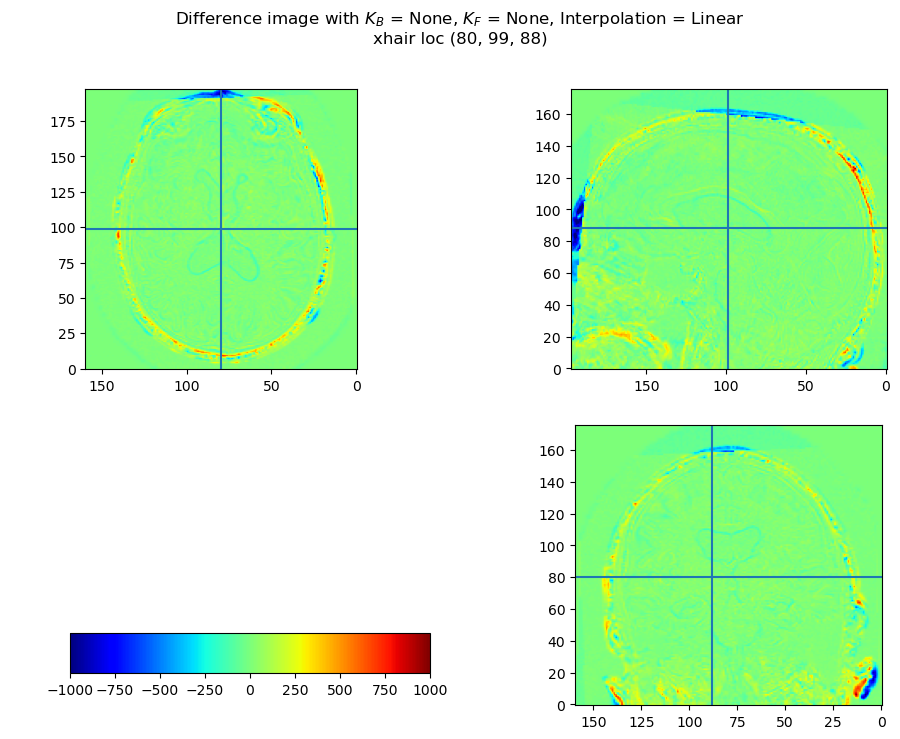

In [17]:
diff2 = my_transform_image(I_ref, I_mov, A, b, method='linear') - I_ref

my_view(diff2, header=hdr_ref, crange=(-1000, 1000), cmap='jet',
        title="Difference image with $K_B$ = None, $K_F$ = None, Interpolation = Linear")

### 3. $K_B$ = Gaussian $\sigma$=2, $K_F$ = Gaussian $\sigma$=2, Interpolation = Linear

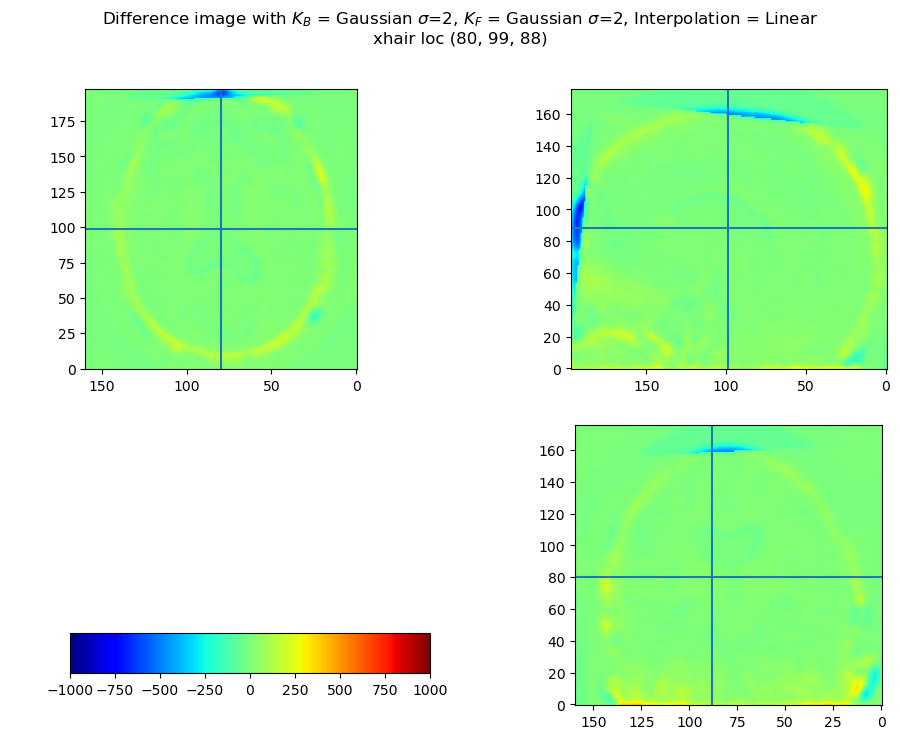

In [18]:
I_ref_lpf = my_gaussian_lpf(I_ref, sigma=2)
I_mov_lpf = my_gaussian_lpf(I_mov, sigma=2)

diff3 = my_transform_image(I_ref_lpf, I_mov_lpf, A, b, method='linear') - I_ref_lpf

my_view(diff3, header=hdr_ref, crange=(-1000, 1000), cmap='jet',
        title="Difference image with $K_B$ = Gaussian $\sigma$=2, $K_F$ = Gaussian $\sigma$=2, Interpolation = Linear")

### 4. $K_B$ = Mean radius=2, $K_F$ = Mean radius=2, Interpolation = Linear

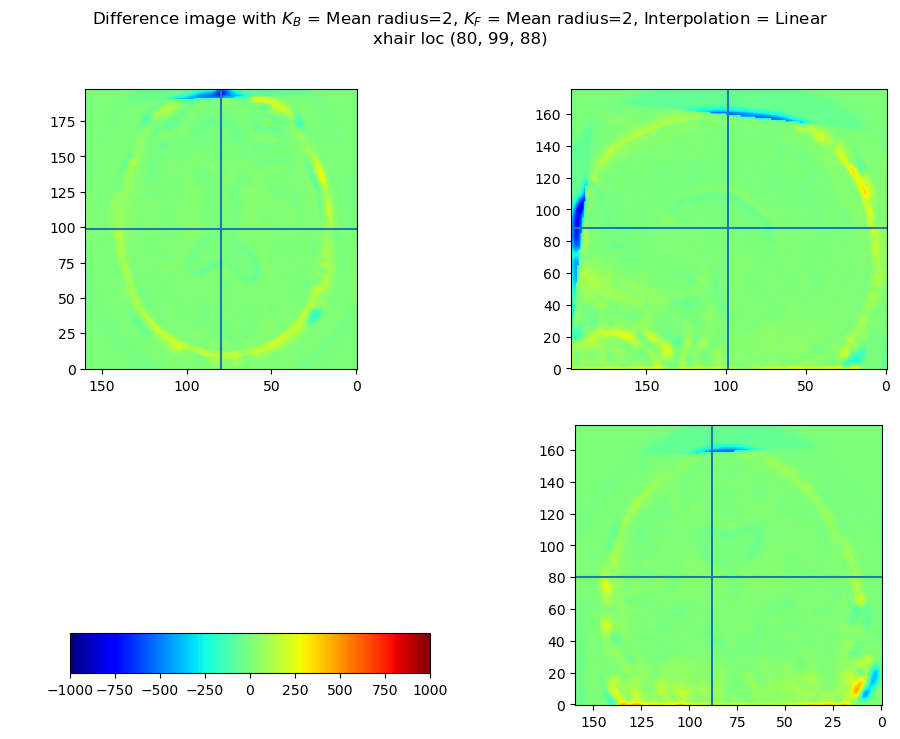

In [19]:
I_ref_lpf = my_mean_lpf(I_ref, radius=2)
I_mov_lpf = my_mean_lpf(I_mov, radius=2)

diff4 = my_transform_image(I_ref_lpf, I_mov_lpf, A, b, method='linear') - I_ref_lpf

my_view(diff4, header=hdr_ref, crange=(-1000, 1000), cmap='jet',
        title="Difference image with $K_B$ = Mean radius=2, $K_F$ = Mean radius=2, Interpolation = Linear")

# 5.3 Quantify intensity difference over regions of interest (10 points)

In [20]:
def my_rms_over_roi(image, seg, label):
    """Compute RMS of a difference image over a label in the segmentation

    :param image: 3D voxel array of the difference image
    :param seg: 3D voxel array with segmentation labels
    :param label: segmentation label
    :return: RMS over ROI
    """
    # binary segmentation mask
    I_seg_mask = np.where(seg==label, 1, 0)
    size_ROI = I_seg_mask.sum()
    
    # difference image of ROI
    diff_roi = np.multiply(image, I_seg_mask)

    diff_roi_squared = np.square(diff_roi)
    
    rms_over_roi = np.sqrt(diff_roi_squared.sum()/size_ROI)
    
    return rms_over_roi    

In [21]:
I_seg, hdr_seg = my_read_nifti("data/seg.nii")

labels = [1, 2, 3]
anatomical_labels = ["Left Hippocampus", "Right Hippocampus", "Lateral Ventricles"]

## RMS over ROI for Gaussian filter with $\sigma$ values from 0.5 to 5.0

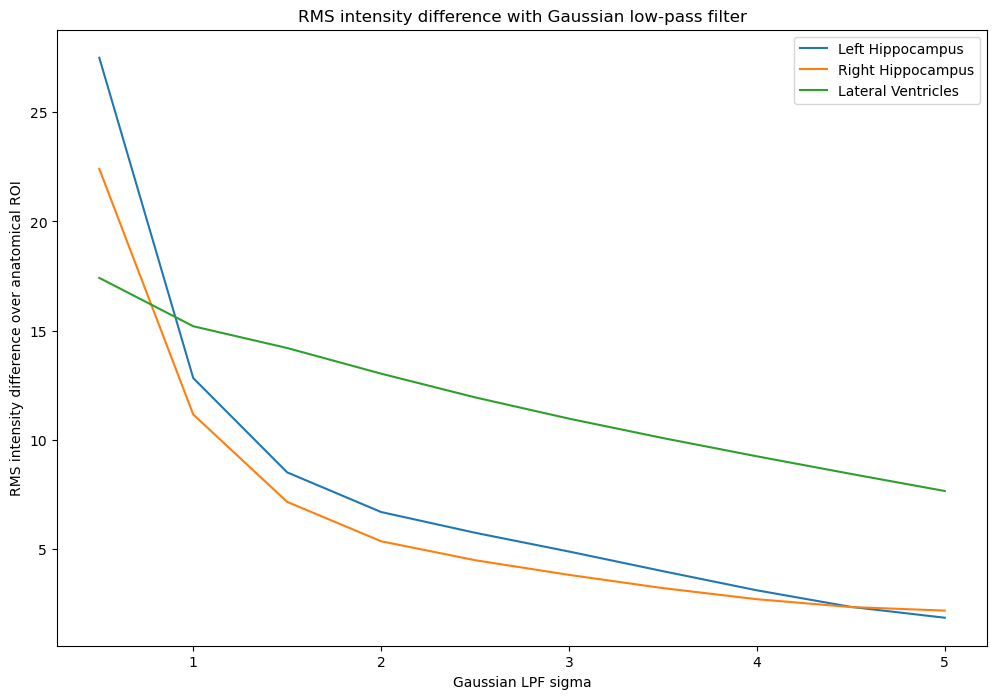

In [40]:
fig, ax = plt.subplots()

sigma_values = np.arange(0.5, 5.5, 0.5)

for label in labels:
    all_rms_over_roi = []
    for sigma in sigma_values:
        I_ref_lpf = my_gaussian_lpf(I_ref, sigma=sigma)
        I_mov_lpf = my_gaussian_lpf(I_mov, sigma=sigma)

        diff = my_transform_image(I_ref_lpf, I_mov_lpf, A, b, method='linear') - I_ref_lpf
        
        rms_over_roi = my_rms_over_roi(diff, I_seg, label)
        
        all_rms_over_roi.append(rms_over_roi)
    
    ax.plot(sigma_values, all_rms_over_roi, label=f"{anatomical_labels[label-1]}")
    ax.set_title("RMS intensity difference with Gaussian low-pass filter")
    ax.set_xlabel("Gaussian LPF sigma")
    ax.set_ylabel("RMS intensity difference over anatomical ROI")
    ax.legend()

plt.show()    
    

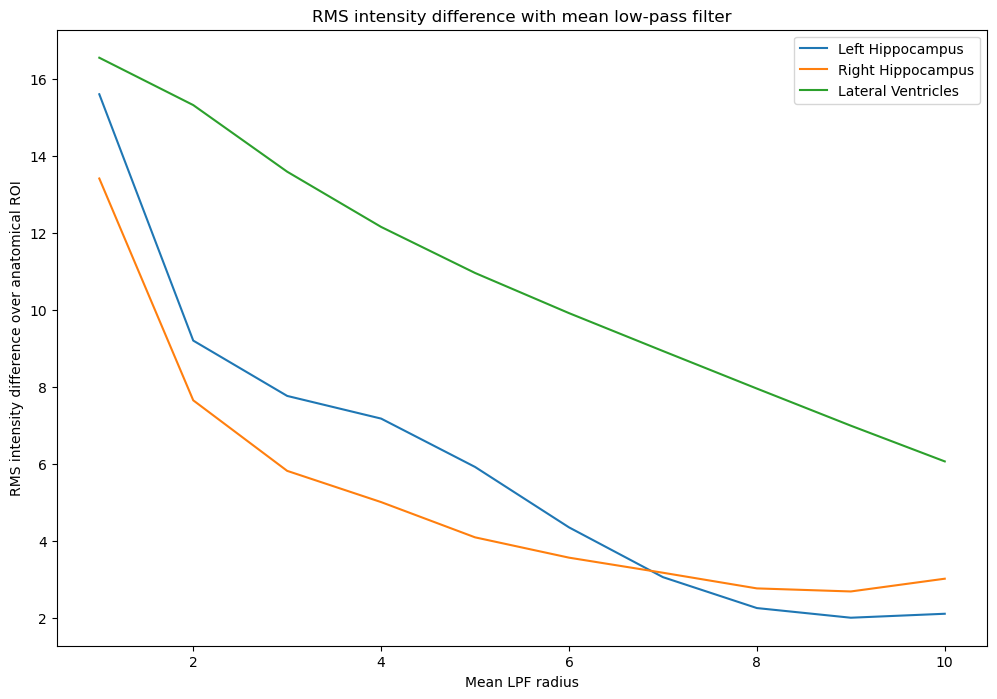

In [41]:
fig, ax = plt.subplots()

radius_values = np.arange(1, 11, 1)

for label in labels:
    all_rms_over_roi = []
    for radius in radius_values:
        I_ref_lpf = my_mean_lpf(I_ref, radius=radius)
        I_mov_lpf = my_mean_lpf(I_mov, radius=radius)

        diff = my_transform_image(I_ref_lpf, I_mov_lpf, A, b, method='linear') - I_ref_lpf
        
        rms_over_roi = my_rms_over_roi(diff, I_seg, label)
        
        all_rms_over_roi.append(rms_over_roi)
    
    ax.plot(radius_values, all_rms_over_roi, label=f"{anatomical_labels[label-1]}")
    ax.set_title("RMS intensity difference with mean low-pass filter")
    ax.set_xlabel("Mean LPF radius")
    ax.set_ylabel("RMS intensity difference over anatomical ROI")
    ax.legend()

plt.show()    
    

# 6.1 Loading 3D images into pytorch tensors (5 points)

In [24]:
T_ref = torch.from_numpy(I_ref).unsqueeze(0).unsqueeze(0)
print(T_ref.dtype)
print(T_ref.shape)

torch.float64
torch.Size([1, 1, 160, 198, 176])


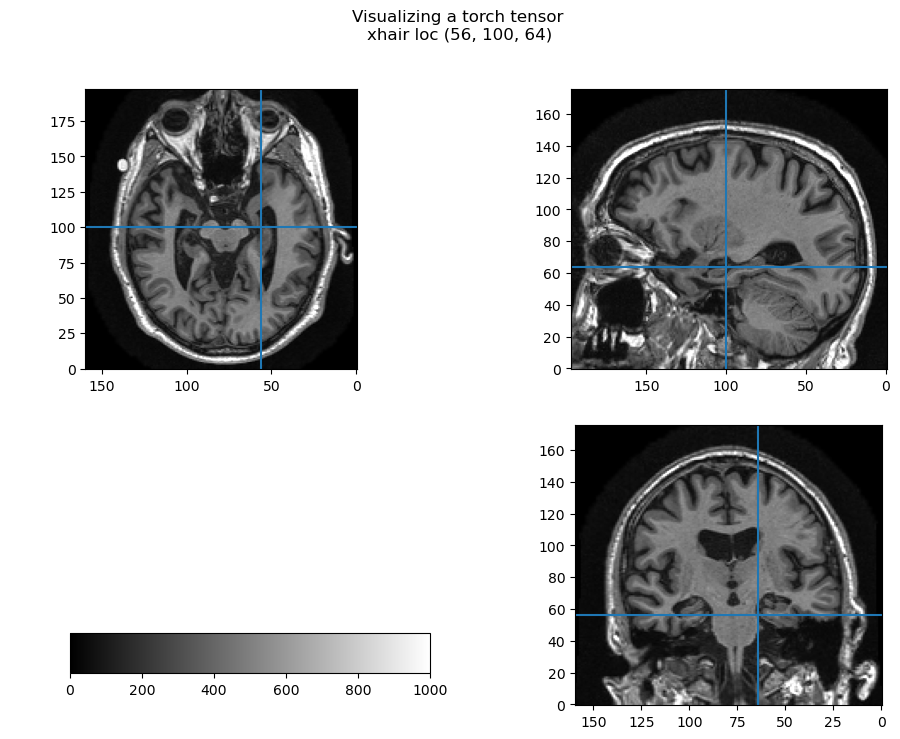

In [25]:
my_view(T_ref.squeeze().detach().cpu().numpy(), xhair=(56,100,64), header=hdr_ref,
        crange=(0,1000), title="Visualizing a torch tensor")

# 6.2 Applying affine transformations in pytorch (15 points)
Keeping the convention that $A', b'$ or variable names `A_prime, b_prime` denote pytorch coordinates and $A, b$ or variable names `A, b` denote numpy coordinates. Translation vectors are of shape (3, 1) instead of (3,).

## Numpy to PyTorch

$ W, A, \textbf{b}, \textbf{z}$ are known entities.
 
$$ W(A\textbf{x} + \textbf{b}) + \textbf{z} = A'(W\textbf{x} + \textbf{z}) +\textbf{b}' \>\>\>\>\> \forall \textbf{x} \in \mathbb{R} $$

$$ WA\textbf{x} + W\textbf{b} + \textbf{z} = A'W\textbf{x} + A'\textbf{z} +\textbf{b}' \>\>\>\>\> \ldots (1) $$

Since this expression is true $\forall \textbf{x} \in \mathbb{R}$, we have:

$$ WA = A'W $$
$$ WAW^{-1} = A'WW^{-1} $$
$$ WAW^{-1} = A'I $$
$$ A' = WAW^{-1} $$

Substituting known value of $A'$ in $(1)$, we have:

$$ W\textbf{b} + \textbf{z} = A'\textbf{z} + \textbf{b}' $$
$$ \textbf{b}' = W\textbf{b} + \textbf{z} - A'\textbf{z} $$

In [26]:
def my_numpy_affine_to_pytorch_affine(A, b, img_shape):
    """Convert affine transform (A,b) from numpy to pytorch coordinates

    :param A: 3x3 affine matrix in numpy coordinates
    :param b: 3x1 translation vector in numpy coordinates
    :param img_shape: size of the image to be transformed
    :return: converted affine transform in pytorch coordinates
    """
    (Sx, Sy, Sz) = img_shape
    W = np.array([[0, 0, 2/Sz], [0, 2/Sy, 0], [2/Sx, 0, 0]]) # shape (3,3)
    z = np.array([[1/Sz - 1], [1/Sy - 1], [1/Sx - 1]]) # shape (3,1)
    
    A_prime = np.dot(np.dot(W, A), np.linalg.inv(W))
    
    b_prime = np.dot(W, b) + z - np.dot(A_prime, z) 
    
    return A_prime, b_prime


In [27]:
A_prime, b_prime = my_numpy_affine_to_pytorch_affine(A, b, I_ref.shape)
A_prime, b_prime

(array([[ 0.9939    , -0.120375  ,  0.04881818],
        [ 0.08791111,  1.001     ,  0.03361616],
        [-0.04499   , -0.0314325 ,  1.0003    ]]),
 array([[ 0.18924318],
        [ 0.06270253],
        [-0.00460125]]))

## PyTorch to Numpy

$ W, A', \textbf{b}', \textbf{z}$ are known entities.
 
$$ W(A\textbf{x} + \textbf{b}) + \textbf{z} = A'(W\textbf{x} + \textbf{z}) +\textbf{b}' \>\>\>\>\> \forall \textbf{x} \in \mathbb{R} $$

$$ WA\textbf{x} + W\textbf{b} + \textbf{z} = A'W\textbf{x} + A'\textbf{z} +\textbf{b}' \>\>\>\>\> \ldots (2) $$

Since this expression is true $\forall \textbf{x} \in \mathbb{R}$, we have:

$$ WA = A'W $$
$$ W^{-1}WA = W^{-1}A'W $$
$$ IA = W^{-1}A'W $$
$$ A = W^{-1}A'W $$

From $(2)$, we have:

$$ W\textbf{b} + \textbf{z} = A'\textbf{z} + \textbf{b}' $$
$$ W\textbf{b} = A'\textbf{z} + \textbf{b}' - \textbf{z} $$
$$ W^{-1}W\textbf{b} = W^{-1}(A'\textbf{z} + \textbf{b}' - \textbf{z}) $$
$$ I\textbf{b} = W^{-1}(A'\textbf{z} + \textbf{b}' - \textbf{z}) $$
$$ \textbf{b} = W^{-1}(A'\textbf{z} + \textbf{b}' - \textbf{z}) $$

In [28]:
def my_pytorch_affine_to_numpy_affine(A_prime, b_prime, img_shape):
    """Convert affine transform (A',b') from pytorch to numpy coordinates

    :param A_prime: 3x3 affine matrix in pytorch coordinates
    :param b_prime: 3x1 translation vector in pytorch coordinates
    :param img_shape: size of the image to be transformed
    :return: converted affine transform in numpy coordinates
    """
    (Sx, Sy, Sz) = img_shape
    W = np.array([[0, 0, 2/Sz], [0, 2/Sy, 0], [2/Sx, 0, 0]]) # shape (3,3)
    z = np.array([[1/Sz - 1], [1/Sy - 1], [1/Sx - 1]]) # shape (3,1)
    
    W_inv = np.linalg.inv(W)
    
    A = np.dot(np.dot(W_inv, A_prime), W)
    
    b = np.dot(W_inv, (np.dot(A_prime, z) + b_prime - z))
    
    return A, b

In [29]:
A, b = my_pytorch_affine_to_numpy_affine(A_prime, b_prime, I_ref.shape)
A, b

(array([[ 1.0003, -0.0254, -0.0409],
        [ 0.0416,  1.001 ,  0.0989],
        [ 0.0537, -0.107 ,  0.9939]]),
 array([[ 5.6887],
        [-5.8519],
        [23.4575]]))

## Function to apply affine transform

In [30]:
def my_transform_image_pytorch(T_ref, T_mov, T_A, T_b, mode='bilinear', padding_mode='zeros'):
    """Apply an affine transformation to 3D images represented as PyTorch tensors.

    :param T_ref: 5D tensor of fixed (ref) image 
    :param T_mov: 5D tensor of moving (followup) image
    :param T_A: 3x3 affine matrix in PyTorch coordinate space
    :param T_b: 3x1 translation vector in PyTorch coordinate space
    :param mode: interpolation mode, defaults to 'bilinear'
    :param padding_mode: padding mode, defaults to 'zeros'
    :return: 5D tensor of transformed moving image
    
    is this relevant?
    https://github.com/pytorch/pytorch/issues/35775#issuecomment-705702703
    """ 
    N = 1
    C = 3
    (D, H, W) = T_ref.shape[2:] # (160, 198, 176)

    # --------- working solution do not touch -------------#
    
    # concatenated transformation matrix
    theta = torch.cat((T_A, T_b), 1).unsqueeze(0) # theta shape (N, 3, 4)
        
    Xp = tfun.affine_grid(theta, size=(N, C, D, H, W), align_corners=False) # Xp shape [N, D, H, W, 3]
    
    T_res = tfun.grid_sample(T_mov, Xp, mode=mode, padding_mode=padding_mode, align_corners=False)
    
    # --------- working solution do not touch -------------#
    
    # Xp = tfun.affine_grid(torch.ones(3,4).unsqueeze(0), size=(N, C, D, H, W), align_corners=False) # Xp shape [N, D, H, W, 3]
    # Xp_reshaped = torch.reshape(Xp, shape=(-1, 3))
    
    # print(Xp_reshaped.shape)
    # print(T_A.shape)
    
    # TXp = torch.mm(T_A, Xp_reshaped.T) + T_b   
    
    # print(TXp.shape)
    
    # TXp_tmp = torch.reshape(TXp, shape=(-1, 3))
    # print(TXp_tmp.shape)
    # TXp_reshaped = torch.reshape(TXp_tmp, shape=Xp.shape)
        
    # T_res = tfun.grid_sample(T_mov.float(), TXp_reshaped, mode=mode, padding_mode=padding_mode, align_corners=False)
        
    return T_res
     

In [31]:
T_mov = torch.from_numpy(I_mov).unsqueeze(0).unsqueeze(0)

T_A = torch.tensor(A_prime)
T_b = torch.tensor(b_prime)

T_res = my_transform_image_pytorch(T_ref, T_mov, T_A, T_b)

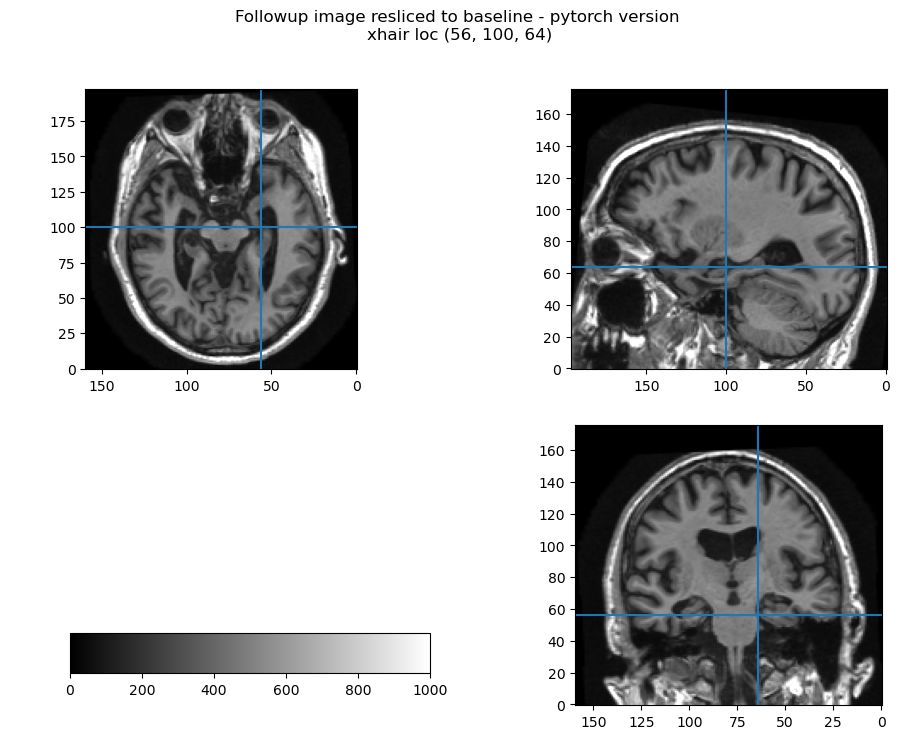

In [32]:
my_view(T_res.squeeze().detach().cpu().numpy(), xhair=(56,100,64), header=hdr_mov, crange=(0,1000),
        title="Followup image resliced to baseline - pytorch version")

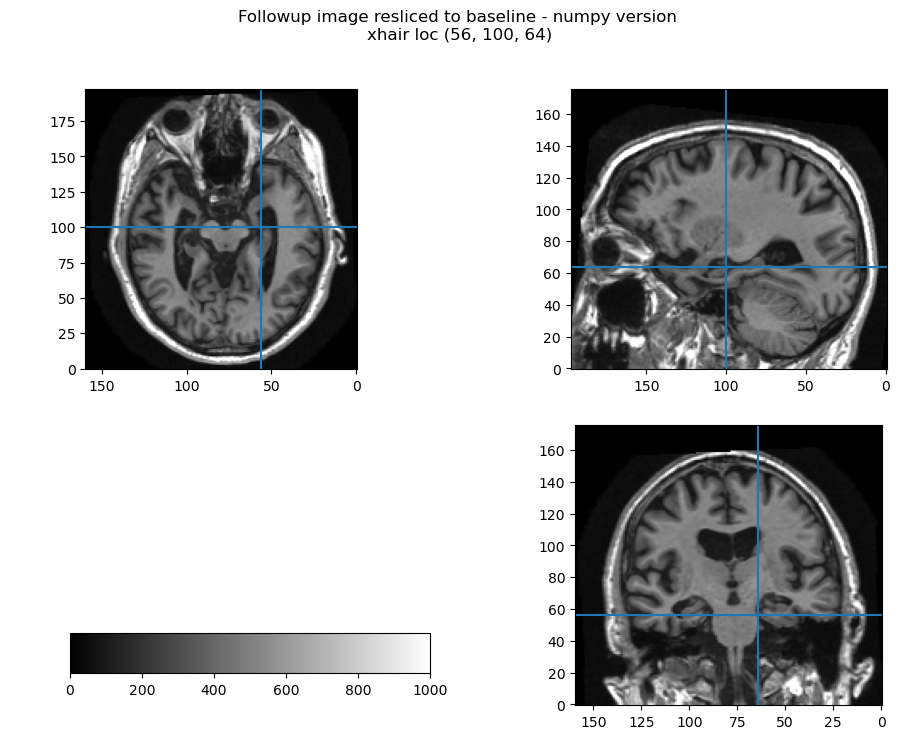

In [33]:
my_view(I_res, xhair=(56,100,64), header=hdr_mov, crange=(0, 1000),
        title="Followup image resliced to baseline - numpy version")

In [34]:
I_diff = I_res - T_res.squeeze().detach().cpu().numpy()

for label in (1,2,3):
    print(f"RMS over label {label}, is {my_rms_over_roi(I_diff, I_seg, label)}")

RMS over label 1, is 9.898406182697044e-13
RMS over label 2, is 1.0949252760355945e-12
RMS over label 3, is 8.408149659801579e-13


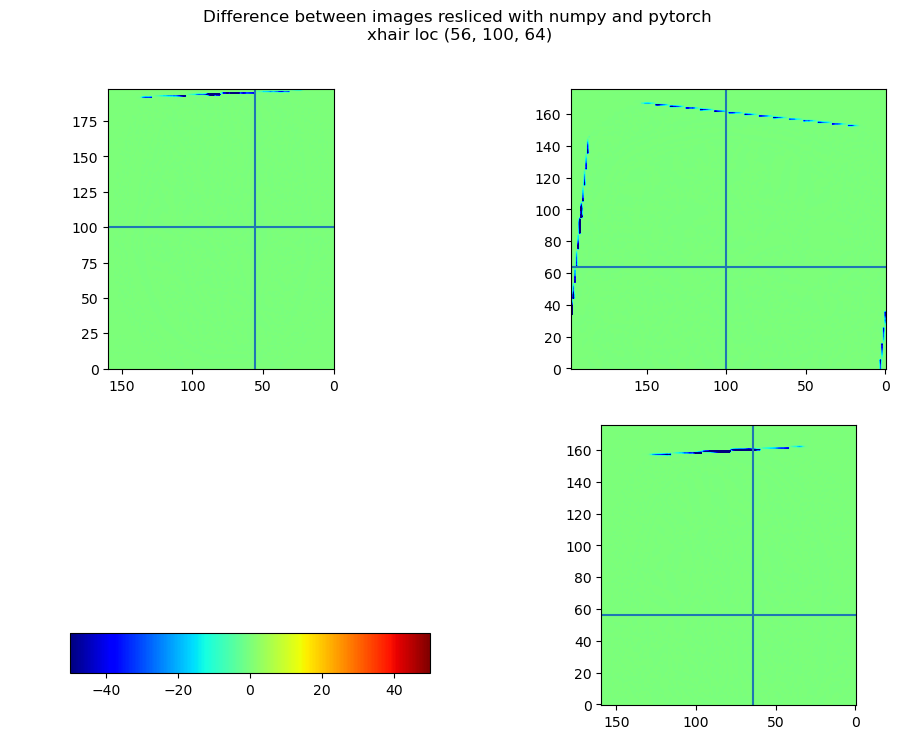

In [35]:
my_view(I_diff, xhair=(56, 100, 64), crange=(-50, 50), cmap='jet', 
        title="Difference between images resliced with numpy and pytorch")

# 6.3 Affine registration using LBFGS optimizer (10 points)

## Objective function for affine registration

In [36]:
def my_affine_objective_fn(T_ref, T_mov, T_A, T_b):
    """Compute the affine registration objective function.

    :param T_ref: 5D tensor of reference (fixed) image
    :param T_mov: 5D tensor of followup (moving) image
    :param T_A: 3x3 affine matrix in PyTorch coordinate space
    :param T_b: 3x1 translation vector in PyTorch coordinate space
    :return: RMS differnece between the reference image and transformed moving image
    """
    T_res = my_transform_image_pytorch(T_ref, T_mov, T_A, T_b)
    
    criterion = torch.nn.MSELoss()
    
    loss = torch.sqrt(criterion(T_ref, T_res))
    
    loss.requires_grad_()

    return loss

In [37]:
my_affine_objective_fn(T_ref, T_mov, T_A, T_b)

tensor(87.0636, dtype=torch.float64, requires_grad=True)

In [38]:
# Create tensors T_A and T_b and track their partial derivatives
T_A = torch.tensor(A_prime, requires_grad=True) 
T_b = torch.tensor(b_prime, requires_grad=True)

# Compute the objective function (forward pass)
obj = my_affine_objective_fn(T_ref, T_mov, T_A, T_b)

# Compute the partial derivatives of the objective function with respect to 
# elements of T_A and T_b automatically (backward pass)
obj.backward()

# Print the objective function value and partial derivatives
obj, T_A.grad, T_b.grad

(tensor(87.0636, dtype=torch.float64, grad_fn=<SqrtBackward0>),
 tensor([[-14.9920, -78.1983,  29.2935],
         [ 52.9782, 164.1723,   3.8241],
         [-37.4395,  42.8367, -68.0659]], dtype=torch.float64),
 tensor([[ 105.6441],
         [-576.0894],
         [ 329.3974]], dtype=torch.float64))

In [39]:
# Starting point for optimization - identity affine transform. Note that 
# the LBFGS implementation in PyTorch requires all the parameters (i.e. 
# variables that we are optimizing over) to be contained in a single
# tensor, which we call T_opt
T_opt = torch.tensor(np.eye(4,4), requires_grad=True)

# Objective function for optimization, a wrapper around my_affine_objective_fn
f_opt = lambda : my_affine_objective_fn(T_ref, T_mov, T_opt[0:3,0:3], T_opt[0:3,3].unsqueeze(1))

# Initialize the LBFGS optimizer with a line search routine
optimizer = torch.optim.LBFGS([T_opt], history_size=10, max_iter=4, 
                              line_search_fn="strong_wolfe")

# Keep track of the objective function values over the course of optimization
opt_history = []

# Run for a few iterations
for i in range(50):
    optimizer.zero_grad()
    objective = f_opt()
    objective.backward()
    optimizer.step(f_opt) 
    opt_history.append(objective.item())
    print('Iter %03d Obj %8.4f' % (i, objective.item()))

Iter 000 Obj 257.0808
Iter 001 Obj 245.0047
Iter 002 Obj 204.0881
Iter 003 Obj 179.8948
Iter 004 Obj 178.8143
Iter 005 Obj 171.0298
Iter 006 Obj 162.0617
Iter 007 Obj 158.8621
Iter 008 Obj 154.1730
Iter 009 Obj 152.7394
Iter 010 Obj 151.7410
Iter 011 Obj 147.4679
Iter 012 Obj 140.7462
Iter 013 Obj 126.1307
Iter 014 Obj 114.9791
Iter 015 Obj 103.2220
Iter 016 Obj  96.2897
Iter 017 Obj  92.8099
Iter 018 Obj  88.8513
Iter 019 Obj  87.5687
Iter 020 Obj  87.1025
Iter 021 Obj  86.9941
Iter 022 Obj  86.7004
Iter 023 Obj  86.5624
Iter 024 Obj  86.4540
Iter 025 Obj  86.4327
Iter 026 Obj  86.4279
Iter 027 Obj  86.4266
Iter 028 Obj  86.4237
Iter 029 Obj  86.4235
Iter 030 Obj  86.4234
Iter 031 Obj  86.4234
Iter 032 Obj  86.4234
Iter 033 Obj  86.4234
Iter 034 Obj  86.4234
Iter 035 Obj  86.4234
Iter 036 Obj  86.4234
Iter 037 Obj  86.4234
Iter 038 Obj  86.4234
Iter 039 Obj  86.4234
Iter 040 Obj  86.4234
Iter 041 Obj  86.4234
Iter 042 Obj  86.4234
Iter 043 Obj  86.4234
Iter 044 Obj  86.4234
Iter 045 O